In [1]:
import torch
from models.DiffusionModel import DiffusionUNet
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision import datasets
import torchvision.transforms as transforms
import gc

In [2]:
torch.mps.empty_cache()
gc.collect()

799

In [3]:
out_res = (16,16)
device = "mps"
learning_rate = 3E-4
num_epochs = 70
batch_size = 64
in_channels = 1
T = 1000
torch.manual_seed(42)

In [4]:
transform = transforms.Compose([
			transforms.Resize(out_res),
			transforms.CenterCrop(out_res),
			transforms.ToTensor(),
			#transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
			])

#train_set = datasets.ImageFolder("Data/celeb", transform=transform)
train_set = datasets.MNIST(root=".", download=True, transform=transform)

In [5]:
model = DiffusionUNet(in_channels=in_channels, resolution=out_res[0], attn_resolutions=[8], ch_mult=(1,2,2), channels=16, time_steps=T).to(device)

In [6]:
from torch.optim import AdamW

loss_fn = nn.MSELoss()
optim = AdamW(model.parameters(), lr=learning_rate)

In [7]:
def epoch(imgs):
    optim.zero_grad()
    
    times = torch.randint(0, T,(batch_size,))
    noises = torch.randn_like(imgs)
    noisy_imgs = model.schedule.add_noise(imgs, noises, times)

    pred_noises = model(noisy_imgs.to(device), (times))

    loss = loss_fn(pred_noises.cpu(), noises)
    loss.backward()
    optim.step()

    del noisy_imgs
    return loss.item()

100%|██████████| 938/938 [01:05<00:00, 14.32it/s]


epoch   1 	  loss 0.0216


<Figure size 640x480 with 0 Axes>

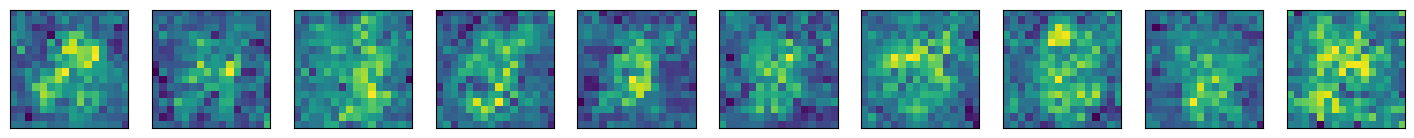

100%|██████████| 938/938 [01:04<00:00, 14.46it/s]


epoch   2 	  loss 0.0020


100%|██████████| 938/938 [01:07<00:00, 13.95it/s]


epoch   3 	  loss 0.0013


<Figure size 640x480 with 0 Axes>

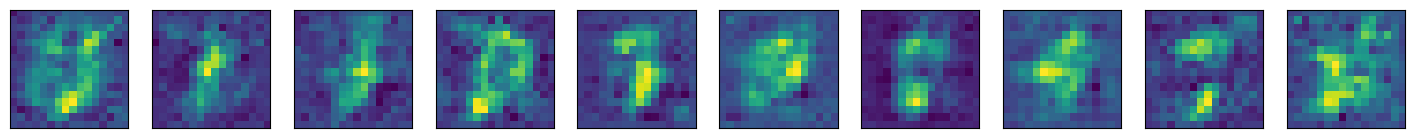

100%|██████████| 938/938 [01:06<00:00, 14.01it/s]


epoch   4 	  loss 0.0009


100%|██████████| 938/938 [01:07<00:00, 13.98it/s]


epoch   5 	  loss 0.0008


<Figure size 640x480 with 0 Axes>

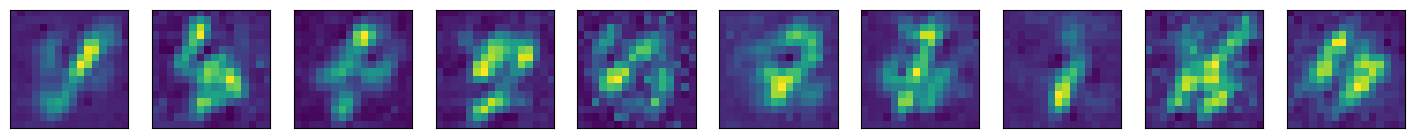

100%|██████████| 938/938 [01:07<00:00, 14.00it/s]


epoch   6 	  loss 0.0008


100%|██████████| 938/938 [01:07<00:00, 13.81it/s]


epoch   7 	  loss 0.0007


<Figure size 640x480 with 0 Axes>

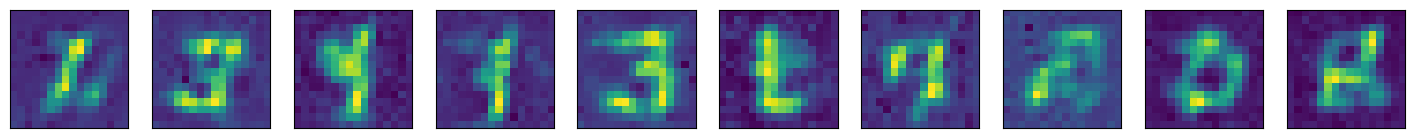

100%|██████████| 938/938 [01:07<00:00, 13.89it/s]


epoch   8 	  loss 0.0008


 29%|██▊       | 269/938 [00:19<00:48, 13.74it/s]


KeyboardInterrupt: 

In [8]:
n_samples = 10
gen_noise = torch.randn(size=(n_samples,in_channels,*out_res))
data_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=0)
n_it = len(train_set)//batch_size +1

for e in range(num_epochs):
    bar = tqdm(range(len(data_loader)))
    epoch_loss = 0
    model.train()
    for i in bar:
        imgs, _ = next(iter(data_loader))
        loss = epoch(imgs)
        epoch_loss += loss
        torch.mps.synchronize()
    epoch_loss = epoch_loss/len(data_loader)
    print(f"epoch {e+1:3.0f} \t  loss {epoch_loss:4.4f}")
    if e%2 == 0:
        model.eval()
        plt.clf()
        fig, axs = plt.subplots(1, n_samples, figsize=(18,2))
        out_imgs = model.reverse_diffusion(gen_noise.to(device), diffusion_steps=100) 
        #model.sample_images(gen_noise.to(device), diffusion_steps=100, schedule=schedule).cpu()
        for i in range(n_samples):
            axs[i].imshow(out_imgs[i].permute(1,2,0))
            axs[i].set_xticks([])
            axs[i].set_yticks([])
        plt.show()
        #plt.savefig(os.path.join(check_point_dir , 'img_schedule_%i'%(n_schedule)))
        gen_noise.to('cpu')


In [ ]:
out_imgs[0]